<a href="https://colab.research.google.com/github/jongwoonalee/jongwoonalee.github.io/blob/main/Bladder_USCAP_2025_LambdaLabs_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이전 gpu해제

In [ ]:
# !fuser -k /dev/nvidia*
# import torch, gc
# torch.cuda.empty_cache()
# gc.collect()
# !kill -9 -1


 필요한 라이브러리 설치 및 임포트

In [ ]:
# 필요한 라이브러리 설치
!pip install torch torchvision pandas matplotlib scikit-learn tqdm pillow opencv-python seaborn scikit-image
# 필요한 라이브러리 임포트
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import re
import zipfile
import shutil
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
# from google.colab import drive  # Google Colab 관련 임포트 제거
import time
import random
from skimage.filters import threshold_otsu
# 기기 설정 (GPU 사용 가능 여부 확인)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 중인 기기: {device}")
# 랜덤 시드 설정 (재현성 확보)
def set_seed(seed=42):
    """
    재현성 확보를 위한 랜덤 시드 설정
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

## 2. 데이터 로드 및 전처리

In [ ]:
## 이미지, 엑셀 파일 불러오기 (여기서부터 - 031025)

In [ ]:
import os
import subprocess
import zipfile

# openpyxl 설치 확인 및 설치
try:
    import pandas as pd
    # openpyxl 설치 확인
    pd.read_excel("test.xlsx", engine="openpyxl")
except ImportError:
    print("📥 openpyxl 라이브러리 설치 중...")
    subprocess.check_call(["pip", "install", "openpyxl"])
    import pandas as pd
    print("✅ openpyxl 설치 완료!")
except FileNotFoundError:
    # 테스트용 파일이 없는 경우는 무시
    import pandas as pd
    print("✅ pandas와 openpyxl이 준비되었습니다.")

# 🔹 Lambda Labs 서버 경로
zip_path = "/home/ubuntu/ExternalUSB_Bladder_240710.zip"  # 업로드한 ZIP 파일
base_dir = "/home/ubuntu/ExternalUSB_Bladder_240710"  # 압축 해제 후 저장할 디렉토리
excel_path = "/home/ubuntu/MIL_TURB_240918_Modified_LambdaLabs.xlsx"  # 업로드한 엑셀 파일 경로

# 이하 코드는 동일
# 🔹 ZIP 파일이 존재하면 압축 해제
if os.path.exists(zip_path):
    if not os.path.exists(base_dir):  # 이미 압축이 풀려있는지 확인
        print(f"📦 ZIP 파일을 압축 해제 중: {zip_path} → {base_dir}")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall("/home/ubuntu/")
        print("✅ 압축 해제 완료!")
    else:
        print("🔹 이미 압축이 해제된 상태입니다.")
else:
    print(f"❌ ZIP 파일을 찾을 수 없습니다: {zip_path}")

# 📌 압축 해제 후 폴더 내 확인
if os.path.exists(base_dir):
    print(f"📂 압축 해제된 폴더 확인: {os.listdir(base_dir)[:5]}")  # 상위 5개 파일 출력
else:
    print("❌ 압축 해제된 폴더가 없습니다.")

# 🔹 데이터 경로 설정
c_til_dir = os.path.join(base_dir, "C_TIL")
p_til_dir = os.path.join(base_dir, "P_TIL")
print(f"📂 C_TIL 경로: {c_til_dir}")
print(f"📂 P_TIL 경로: {p_til_dir}")

# 📌 엑셀 파일 로드 확인
if os.path.exists(excel_path):
    labels_df = pd.read_excel(excel_path, engine="openpyxl")
    print(f"✅ 엑셀 파일 로드 성공: {excel_path}")
    print(f"📊 데이터 형태: {labels_df.shape}")
else:
    print(f"❌ 엑셀 파일을 찾을 수 없습니다: {excel_path}")

✅ pandas와 openpyxl이 준비되었습니다.
❌ ZIP 파일을 찾을 수 없습니다: /home/ubuntu/ExternalUSB_Bladder_240710.zip
❌ 압축 해제된 폴더가 없습니다.
📂 C_TIL 경로: /home/ubuntu/ExternalUSB_Bladder_240710/C_TIL
📂 P_TIL 경로: /home/ubuntu/ExternalUSB_Bladder_240710/P_TIL
❌ 엑셀 파일을 찾을 수 없습니다: /home/ubuntu/MIL_TURB_240918_Modified_LambdaLabs.xlsx


파일이름정리, 매치

In [ ]:
# 파일 이름에서 식별자 추출 함수
def extract_identifier(filename):
    """
    다양한 패턴의 파일명에서 슬라이드 ID를 추출

    Args:
        filename (str): 파일 이름

    Returns:
        tuple: (추출된 ID, 파일 확장자)
    """
    name, ext = os.path.splitext(filename)

    # 대괄호 앞 부분만 사용 (좌표 정보 제거)
    if '[' in name:
        name = name.split('[')[0].strip()

    # 패턴 1: S15-3380 또는 S15-3380_2024-09-09 형식
    m1 = re.match(r'^S(\d+)-(\d+)(?:_\d{4}-\d{2}-\d{2})?', name)
    if m1:
        slide = m1.group(1)  # 예: "15"
        patch = m1.group(2)  # 예: "3380"
        # 패치 번호 길이에 따라 패딩 추가
        if len(patch) == 3:
            patch_padded = "000" + patch  # 3자리면 '000' 추가
        elif len(patch) == 4:
            patch_padded = "00" + patch   # 4자리면 '00' 추가
        elif len(patch) == 5:
            patch_padded = "0" + patch    # 5자리면 '0' 추가
        else:
            patch_padded = patch  # 6자리 이상이면 그대로 유지

        return f"S{slide}{patch_padded}"

    # 패턴 2: S16022792,1A 또는 S16022792;1A 형식
    m2 = re.match(r'^S(\d+)[,;]', name)
    if m2:
        slide_id = m2.group(1)
        return f"S{slide_id}", ext

    # 패턴 3: S16021286 형식 (이미 원하는 형식인 경우)
    m3 = re.match(r'^S(\d{8}|\d{7}|\d{6})', name)
    if m3:
        slide_id = m3.group(1)
        return f"S{slide_id}", ext

    # 어떤 패턴에도 매칭되지 않으면 None 반환
    return None, ext

# 파일 ID를 엑셀 ID 형식으로 변환하는 함수
def convert_file_id_to_excel_format(file_id):
    """
    파일명에서 추출한 ID를 엑셀 ID 형식으로 변환

    Args:
        file_id (str): 파일에서 추출한 ID

    Returns:
        str: 엑셀 형식으로 변환된 ID 또는 변환 실패 시 None
    """
    if file_id is None:
        return None

    # 문자열로 변환
    file_id = str(file_id).strip()

    if "-" in file_id:
        # S15-922 형식을 S15000922 형식으로 변환
        parts = file_id.split("-")
        if len(parts) == 2 and parts[1].isdigit():
            patch = parts[1]

            if len(patch) == 3:
                padded_number = "000" + patch  # 3자리 → '000' 추가
            elif len(patch) == 4:
                padded_number = "00" + patch   # 4자리 → '00' 추가
            elif len(patch) == 5:
                padded_number = "0" + patch    # 5자리 → '0' 추가
            else:
                padded_number = patch          # 6자리 이상 → 그대로 유지

            return f"{parts[0]}{padded_number}"  # 🔴 **여기서 불필요한 '000' 제거**
    elif len(file_id) > 3 and file_id.startswith("S"):
        # ID가 이미 S15004164 형식인 경우 그대로 반환
        return file_id

    # 기타 변환 실패한 경우
    return None

# 엑셀 파일 로드 및 ID 확인
labels_df = pd.read_excel(excel_path)
print("엑셀 파일 로드 성공")
print(f"데이터 형태: {labels_df.shape}")
print("처음 10개 행:")
print(labels_df.head(10))

# 이미지 파일과 레이블 매칭
def match_images_with_labels(c_til_dir, p_til_dir, labels_df):
    """
    이미지 파일과 엑셀 레이블 데이터를 매칭

    Args:
        c_til_dir (str): C_TIL 디렉토리 경로
        p_til_dir (str): P_TIL 디렉토리 경로
        labels_df (DataFrame): 레이블 데이터가 포함된 데이터프레임

    Returns:
        list: 매칭된 샘플 정보 목록
    """
    # 두 폴더에서 모든 이미지 처리
    image_dirs = [dir_path for dir_path in [c_til_dir, p_til_dir] if dir_path is not None]

    if not image_dirs:
        print("데이터 디렉토리가 없습니다.")
        return []

    matched_samples = []

    # 엑셀 ID 집합 생성 (빠른 검색용)
    excel_ids = set(labels_df['Number'].astype(str).values)

    total_images = 0
    matched_images = 0

    for data_dir in image_dirs:
        dir_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        total_images += len(dir_files)

        for filename in tqdm(dir_files, desc=f"{os.path.basename(data_dir)} 처리 중"):
            # 파일명에서 S 다음에 숫자가 오는 패턴 찾기
            match = re.search(r'(S\d+(?:-\d+)?)', filename)
            if match:
                file_id = match.group(1)

                # 파일명이 S로 시작하는지 확인
                if file_id.startswith('S'):
                    excel_format_id = convert_file_id_to_excel_format(file_id)

                    if excel_format_id and excel_format_id in excel_ids:
                        # 엑셀에서 매칭되는 레이블 찾기
                        label_row = labels_df[labels_df['Number'] == excel_format_id]

                        if not label_row.empty:
                            matched_images += 1

                            # T 값 얻기
                            t_value = label_row['T'].values[0]

                            # T≥2이면 T2(1), 아니면 T1(0)
                            try:
                                t_label = 1 if float(t_value) >= 2 else 0
                            except:
                                print(f"경고: {excel_format_id}의 T 값이 숫자가 아닙니다: {t_value}")
                                t_label = 0

                            # 재발 여부 가져오기
                            recur = label_row['Recur'].values[0] if 'Recur' in label_row.columns else None
                            recur_label = int(recur) if pd.notna(recur) else None

                            image_path = os.path.join(data_dir, filename)
                            matched_samples.append({
                                'patient_id': excel_format_id,  # 환자 ID
                                'image_path': image_path,
                                't_label': t_label,  # T1/T2 분류 (0: T1, 1: T2)
                                'recur_label': recur_label,  # 재발 여부 (0: 재발 없음, 1: 재발 있음)
                                'original_t': t_value  # 원본 T 값
                            })

    print(f"\n총 {total_images}개 이미지 중 {matched_images}개 이미지가 레이블과 매칭되었습니다.")

    # T1/T2 분포 확인
    if matched_samples:
        t1_count = sum(1 for sample in matched_samples if sample['t_label'] == 0)
        t2_count = sum(1 for sample in matched_samples if sample['t_label'] == 1)
        print(f"T1 (레이블 0): {t1_count}개 ({t1_count/len(matched_samples)*100:.1f}%)")
        print(f"T2 (레이블 1): {t2_count}개 ({t2_count/len(matched_samples)*100:.1f}%)")

    # 재발 여부 분포 확인
    recur_samples = [s for s in matched_samples if s['recur_label'] is not None]
    if recur_samples:
        recur_0_count = sum(1 for sample in recur_samples if sample['recur_label'] == 0)
        recur_1_count = sum(1 for sample in recur_samples if sample['recur_label'] == 1)
        print(f"재발 없음 (0): {recur_0_count}개 ({recur_0_count/len(recur_samples)*100:.1f}%)")
        print(f"재발 있음 (1): {recur_1_count}개 ({recur_1_count/len(recur_samples)*100:.1f}%)")

    # 이미지 크기 확인 (첫 번째 이미지)
    if matched_samples:
        try:
            first_img = cv2.imread(matched_samples[0]['image_path'])
            print(f"\n첫 번째 이미지 크기: {first_img.shape}")
        except:
            print("\n첫 번째 이미지를 로드할 수 없습니다.")

    return matched_samples

# 매칭 실행
all_samples = match_images_with_labels(c_til_dir, p_til_dir, labels_df)

if all_samples:
    print("\n처음 5개 매칭 결과:")
    for i, sample in enumerate(all_samples[:5]):
        print(f"{i+1}. 환자 ID: {sample['patient_id']}")
        print(f"   이미지 경로: {os.path.basename(sample['image_path'])}")
        print(f"   T 값: {sample['original_t']} -> 이진 분류: {sample['t_label']} (T{'2' if sample['t_label']==1 else '1'})")
        print(f"   Recur: {sample['recur_label']} ({'재발' if sample['recur_label']==1 else '재발 없음' if sample['recur_label']==0 else '정보 없음'})")

# 환자 ID별로 이미지 그룹화
def group_images_by_patient(matched_samples):
    """
    매칭된 이미지 샘플을 환자 ID별로 그룹화

    Args:
        matched_samples (list): 매칭된 이미지 샘플 목록

    Returns:
        dict: 환자 ID를 키로, 해당 환자의 이미지 리스트를 값으로 하는 딕셔너리
    """
    patient_data = {}

    for sample in matched_samples:
        patient_id = sample['patient_id']

        if patient_id not in patient_data:
            patient_data[patient_id] = {
                't_label': sample['t_label'],
                'recur_label': sample['recur_label'],
                'images': []
            }

        patient_data[patient_id]['images'].append(sample['image_path'])

    # 환자 수 및 이미지 수 통계
    patient_count = len(patient_data)
    image_counts = [len(data['images']) for data in patient_data.values()]
    total_images = sum(image_counts)
    avg_images = total_images / patient_count if patient_count > 0 else 0

    print(f"\n총 환자 수: {patient_count}")
    print(f"총 이미지 수: {total_images}")
    print(f"환자당 평균 이미지 수: {avg_images:.2f}")
    print(f"환자당 최소 이미지 수: {min(image_counts) if image_counts else 0}")
    print(f"환자당 최대 이미지 수: {max(image_counts) if image_counts else 0}")

    return patient_data

# 환자별 데이터 그룹화
patient_data = group_images_by_patient(all_samples)


FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/MIL_TURB_240918_Modified_LambdaLabs.xlsx'

왜 매칭안됐지

In [ ]:
# 매칭 안 된 이미지 확인
def check_unmatched_images(c_til_dir, p_til_dir, matched_samples):
    # 매칭된 이미지 경로 집합 생성
    matched_paths = set([sample['image_path'] for sample in matched_samples])

    # 모든 디렉토리의 모든 이미지 경로 집합 생성
    all_image_paths = set()

    for data_dir in [c_til_dir, p_til_dir]:
        if data_dir is None:
            continue

        dir_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for filename in dir_files:
            image_path = os.path.join(data_dir, filename)
            all_image_paths.add(image_path)

    # 매칭 안된 이미지 찾기
    unmatched_paths = all_image_paths - matched_paths

    print(f"\n총 이미지 수: {len(all_image_paths)}")
    print(f"매칭된 이미지 수: {len(matched_paths)}")
    print(f"매칭 안된 이미지 수: {len(unmatched_paths)}")

    # 매칭 안된 이미지 샘플 확인 (처음 5개)
    print("\n매칭 안된 이미지 샘플 (처음 5개):")
    for i, path in enumerate(list(unmatched_paths)[:5]):
        filename = os.path.basename(path)

        # 패턴 추출 시도
        pattern = re.search(r'(S\d+(?:-\d+)?)', filename)
        extracted_id = pattern.group(1) if pattern else "패턴 없음"

        # 변환 시도
        converted_id = convert_file_id_to_excel_format(extracted_id) if pattern else "변환 불가"

        print(f"{i+1}. 파일명: {filename}")
        print(f"   추출된 ID: {extracted_id}")
        print(f"   변환된 ID: {converted_id}")

        # 이 ID가 엑셀에 있는지 확인
        if converted_id != "변환 불가" and converted_id in set(labels_df['Number'].astype(str).values):
            print(f"   엑셀에 ID 존재함 - 다른 이유로 매칭 실패")
        else:
            print(f"   엑셀에 ID 없음")

    # ID 추출 패턴 분석
    print("\n매칭 안된 이미지 파일명 패턴 분석:")
    patterns = {}
    no_patterns = 0

    for path in unmatched_paths:
        filename = os.path.basename(path)
        pattern = re.search(r'(S\d+(?:-\d+)?)', filename)

        if pattern:
            pattern_str = pattern.group(1)
            patterns[pattern_str] = patterns.get(pattern_str, 0) + 1
        else:
            no_patterns += 1

    print(f"패턴 없는 파일 수: {no_patterns}")
    print("상위 20개 패턴:")
    for pattern, count in sorted(patterns.items(), key=lambda x: x[1], reverse=True)[:50]:
        print(f"{pattern}: {count}개")

    return unmatched_paths

# 실행
unmatched_images = check_unmatched_images(c_til_dir, p_til_dir, all_samples)


총 이미지 수: 8707
매칭된 이미지 수: 5673
매칭 안된 이미지 수: 3034

매칭 안된 이미지 샘플 (처음 5개):
1. 파일명: S17013859,2A, [d=2.01814,x=115728,y=138461,w=2067,h=2066].png
   추출된 ID: S17013859
   변환된 ID: S17013859
   엑셀에 ID 없음
2. 파일명: S17029407,A [d=2.01814,x=26866,y=61997,w=2066,h=2067].png
   추출된 ID: S17029407
   변환된 ID: S17029407
   엑셀에 ID 없음
3. 파일명: S18008213,A, [d=2.01814,x=39265,y=252123,w=2067,h=2066].png
   추출된 ID: S18008213
   변환된 ID: S18008213
   엑셀에 ID 없음
4. 파일명: S18002009,A, [d=2.01814,x=24799,y=132261,w=2067,h=2067].png
   추출된 ID: S18002009
   변환된 ID: S18002009
   엑셀에 ID 없음
5. 파일명: S17009533,C, [d=2.01814,x=53731,y=196325,w=2067,h=2067].png
   추출된 ID: S17009533
   변환된 ID: S17009533
   엑셀에 ID 없음

매칭 안된 이미지 파일명 패턴 분석:
패턴 없는 파일 수: 0
상위 20개 패턴:
S15-19106: 247개
S18031270: 190개
S21015978: 183개
S18002009: 143개
S18020769: 127개
S17009533: 119개
S17013859: 109개
S18028612: 107개
S18030800: 99개
S18012025: 96개
S18008871: 90개
S21015235: 85개
S18020606: 83개
S18017880: 83개
S18015099: 82개
S16021538: 79개
S16003816: 78개
S15

## 3. 다중 해상도 이미지 생성 함수

```
# 코드로 형식 지정됨
```



다중 해상도 예시: S17021121,A, [d=2.01814,x=144661,y=82663,w=2066,h=2067].png


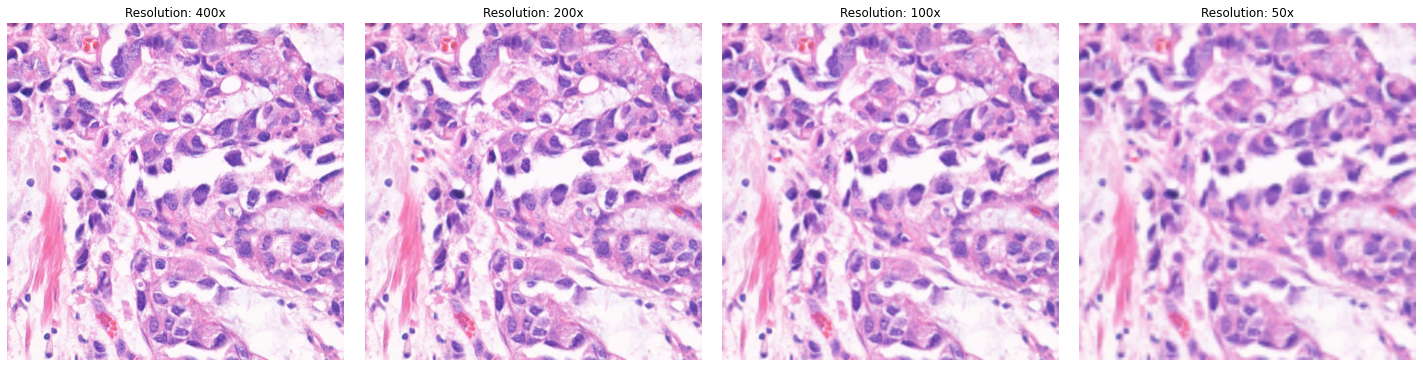

In [ ]:
def create_multiscale_images(image_path):
    """
    주어진 이미지 경로에서 원본(400x) 이미지를 로드하고,
    200x, 100x, 50x 배율로 다운샘플링한 후 다시 원본 크기로 업샘플링

    Args:
        image_path (str): 이미지 파일 경로

    Returns:
        dict: 다양한 해상도의 이미지를 포함하는 딕셔너리
    """
    # 원본 이미지 로드 및 색상 변환
    img_400x = cv2.imread(image_path)
    if img_400x is None:
        raise ValueError(f"이미지를 찾을 수 없습니다: {image_path}")
    img_400x = cv2.cvtColor(img_400x, cv2.COLOR_BGR2RGB)
    h, w = img_400x.shape[:2]

    # 다운샘플링 후 업샘플링
    # 200x (50% 크기로 줄였다가 원래 크기로 복원)
    img_200x = cv2.resize(img_400x, (max(w//2, 1), max(h//2, 1)), interpolation=cv2.INTER_AREA)
    img_200x_up = cv2.resize(img_200x, (w, h), interpolation=cv2.INTER_LINEAR)

    # 100x (25% 크기로 줄였다가 원래 크기로 복원)
    img_100x = cv2.resize(img_400x, (max(w//4, 1), max(h//4, 1)), interpolation=cv2.INTER_AREA)
    img_100x_up = cv2.resize(img_100x, (w, h), interpolation=cv2.INTER_LINEAR)

    # 50x (12.5% 크기로 줄였다가 원래 크기로 복원)
    img_50x = cv2.resize(img_400x, (max(w//8, 1), max(h//8, 1)), interpolation=cv2.INTER_AREA)
    img_50x_up = cv2.resize(img_50x, (w, h), interpolation=cv2.INTER_LINEAR)

    return {
        '400x': img_400x,      # 원본 이미지
        '200x': img_200x_up,   # 200x 해상도 시뮬레이션
        '100x': img_100x_up,   # 100x 해상도 시뮬레이션
        '50x': img_50x_up      # 50x 해상도 시뮬레이션
    }

# 다중 해상도 이미지 예시 시각화
def visualize_multiscale_example(image_path):
    """
    다중 해상도 이미지 생성 및 시각화

    Args:
        image_path (str): 이미지 파일 경로
    """
    try:
        multiscale_images = create_multiscale_images(image_path)

        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        for i, (resolution, img) in enumerate(multiscale_images.items()):
            axes[i].imshow(img)
            axes[i].set_title(f'Resolution: {resolution}')
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"이미지 시각화 오류: {str(e)}")

# 첫 번째 이미지로 다중 해상도 예시 확인
if all_samples:
    sample_image_path = all_samples[0]['image_path']
    print(f"다중 해상도 예시: {os.path.basename(sample_image_path)}")
    visualize_multiscale_example(sample_image_path)

## 4. 패치 생성 및 데이터셋 구성

def extract_patches(image, patch_size=128, stride=128):
    """
    이미지에서 패치 추출

    Args:
        image (numpy.ndarray): 입력 이미지
        patch_size (int): 패치 크기
        stride (int): 패치 간 간격

    Returns:
        list: 추출된 패치 목록
    """
    patches = []
    h, w = image.shape[:2]

    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = image[y:y+patch_size, x:x+patch_size]
            patches.append(patch)

    return patches

# 이미지 변환을 위한 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class PatchDataset(Dataset):
    """
    이미지 패치 데이터셋
    """
    def __init__(self, patches, transform=None):
        """
        Args:
            patches (list): 이미지 패치 목록
            transform: 이미지 변환 함수
        """
        self.patches = patches
        self.transform = transform

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        patch = self.patches[idx]

        if self.transform:
            patch = Image.fromarray(patch)
            patch = self.transform(patch)

        return patch
import pickle
import hashlib

# 하이브리드 캐시 클래스 정의
class HybridCache:
    def __init__(self, cache_dir, memory_limit=1000):
        self.memory_cache = {}
        self.memory_limit = memory_limit
        self.disk_cache_dir = cache_dir
        os.makedirs(self.disk_cache_dir, exist_ok=True)

    def get(self, key):
        # 메모리 캐시 확인
        if key in self.memory_cache:
            return self.memory_cache[key]

        # 디스크 캐시 확인
        cache_path = os.path.join(self.disk_cache_dir, f"{key}.pkl")
        if os.path.exists(cache_path):
            try:
                with open(cache_path, 'rb') as f:
                    data = pickle.load(f)
                # 메모리 캐시에 추가
                if len(self.memory_cache) >= self.memory_limit:
                    self.memory_cache.pop(next(iter(self.memory_cache)))
                self.memory_cache[key] = data
                return data
            except:
                return None
        return None

    def set(self, key, value):
        # 디스크에 저장
        cache_path = os.path.join(self.disk_cache_dir, f"{key}.pkl")
        with open(cache_path, 'wb') as f:
            pickle.dump(value, f)

        # 메모리에 저장
        if len(self.memory_cache) >= self.memory_limit:
            self.memory_cache.pop(next(iter(self.memory_cache)))
        self.memory_cache[key] = value

class PatientBagDataset(Dataset):
    """
    환자별 이미지 패치 백(MIL 데이터셋)
    """
    def __init__(self, patient_data, target_type='t_label', transform=None, resolution='400x', patch_size=224, stride=224):
        """
        Args:
            patient_data (dict): 환자별 데이터
            target_type (str): 예측 타겟 유형 ('t_label' 또는 'recur_label')
            transform: 이미지 변환 함수
            resolution (str): 사용할 이미지 해상도
            patch_size (int): 패치 크기
            stride (int): 패치 추출 간격
        """
        self.patient_ids = list(patient_data.keys())
        self.patient_data = patient_data
        self.target_type = target_type
        self.transform = transform
        self.resolution = resolution
        self.patch_size = patch_size
        self.stride = stride
        # 캐시 디렉토리 설정 및 초기화
        self.cache_dir = '/content/drive/MyDrive/bladder_cache'
        self.cache = HybridCache(self.cache_dir)

    def __len__(self):
        return len(self.patient_ids)

def __getitem__(self, idx):
    patient_id = self.patient_ids[idx]
    patient_info = self.patient_data[patient_id]

    # 타겟 레이블 (T 또는 Recur)
    if self.target_type == 't_label':
        label = patient_info['t_label']
    else:  # recur_label
        label = patient_info['recur_label']
        # 값이 None인 경우 처리
        if label is None:
            label = 0  # 기본값 설정

    # 캐시 키 생성 (환자ID + 해상도 + 패치 설정)
    cache_key = hashlib.md5(f"{patient_id}_{self.resolution}_{self.patch_size}_{self.stride}".encode()).hexdigest()

    # 캐시에서 패치 로드 시도
    all_patches = self.cache.get(cache_key)

    # 캐시에 없으면 패치 생성 후 캐싱
    if all_patches is None:
        all_patches = []

        for img_path in patient_info['images']:
            try:
                # 다중 해상도 이미지 생성
                multiscale_images = create_multiscale_images(img_path)
                # 지정된 해상도의 이미지 선택
                img = multiscale_images[self.resolution]
                # 패치 추출
                patches = extract_patches(img, self.patch_size, self.stride)
                all_patches.extend(patches)
            except Exception as e:
                print(f"패치 생성 오류 (환자 {patient_id}, 이미지 {img_path}): {str(e)}")

        # 패치를 캐시에 저장
        self.cache.set(cache_key, all_patches)

    return {
        'patient_id': patient_id,
        'patches': all_patches,
        'label': label
    }

## 5. SEResNet18 모델 및 Top-K MIL 구현



In [ ]:
class SELayer(nn.Module):
    """
    Squeeze-and-Excitation 레이어
    """
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SEResNetBlock(nn.Module):
    """
    SE-ResNet 블록
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, reduction=16):
        super(SEResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SELayer(out_channels, reduction)
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class SEResNet18(nn.Module):
    """
    SE-ResNet18 모델 (사전 훈련된 ResNet18을 기반으로 SE 블록 추가)
    """
    def __init__(self, num_classes=2):
        super(SEResNet18, self).__init__()
        # 사전 훈련된 ResNet18 불러오기
        resnet = models.resnet18(pretrained=True)

        # 특성 추출 부분 (feature extraction)
        self.features = nn.Sequential(*list(resnet.children())[:-2])

        # SE 블록 추가
        self.se = SELayer(512)

        # 특성 벡터로 변환
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        # 분류 헤드
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.se(x)
        x = self.avgpool(x)
        features = x.view(x.size(0), -1)
        logits = self.fc(features)

        return logits, features

class TopKMIL(nn.Module):
    """
    Top-K Multiple Instance Learning 모델
    - Otsu 방법론으로 동적으로 K 결정 (최대 kmax=10)
    """
    def __init__(self, feature_extractor, feature_dim=2048, num_classes=2, k_max=10):
        super(TopKMIL, self).__init__()
        self.feature_extractor = feature_extractor
        self.feature_dim = feature_dim
        self.num_classes = num_classes
        self.k_max = k_max

        # 특성 벡터를 점수로 변환하는 어텐션 메커니즘
        self.attention = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )

        # 분류기
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x_patches):
        """
        MIL 포워드 패스 구현

        Args:
            x_patches (list): 환자의 패치 리스트, 각 패치는 [B, C, H, W] 형태

        Returns:
            tuple: (예측 확률, 선택된 top-k 패치 인덱스)
        """
        # 개별 패치의 특성 추출
        patch_features_list = []
        patch_scores_list = []

        for patch in x_patches:
            _, patch_features = self.feature_extractor(patch)
            patch_features_list.append(patch_features)

            # 각 패치에 대한 어텐션 점수 계산
            patch_scores = self.attention(patch_features)
            patch_scores_list.append(patch_scores)

        # 패치별 특성 및 점수를 텐서로 결합
        patch_features = torch.cat(patch_features_list, dim=0)  # [num_patches, feature_dim]
        patch_scores = torch.cat(patch_scores_list, dim=0)      # [num_patches, 1]

        # Otsu 방법을 사용하여 k 결정 (최대 k_max)
        scores_np = patch_scores.detach().cpu().numpy().flatten()

        if len(scores_np) <= 1:
            # 패치가 하나만 있는 경우, 그 패치만 사용
            k = 1
            _, top_k_indices = torch.topk(patch_scores, k=k, dim=0)
        else:
            try:
                # Otsu 알고리즘을 사용하여 임계값 결정
                threshold = threshold_otsu(scores_np)

                # 임계값보다 큰 점수를 가진 패치 수를 k로 사용 (최대 k_max까지)
                k_from_otsu = (scores_np > threshold).sum()
                k = min(k_from_otsu, self.k_max)
                k = max(k, 1)  # 최소 1개는 선택되도록 함

                # Top-k 패치 선택
                _, top_k_indices = torch.topk(patch_scores, k=k, dim=0)
            except:
                # Otsu 알고리즘 실패 시, 기본값 사용
                k = min(len(scores_np), self.k_max)
                _, top_k_indices = torch.topk(patch_scores, k=k, dim=0)

        # 선택된 Top-k 패치의 특성 추출
        selected_features = torch.index_select(patch_features, 0, top_k_indices.squeeze())

        # Top-k 패치의 특성 평균으로 Bag 표현
        bag_features = torch.mean(selected_features, dim=0, keepdim=True)

        # 분류기를 통한 예측
        logits = self.classifier(bag_features)
        probs = F.softmax(logits, dim=1)

        return probs, top_k_indices.squeeze().tolist()

    def compute_loss(self, probs, true_labels):
        """
        손실 함수 계산

        Args:
            probs: 예측 확률
            true_labels: 실제 레이블

        Returns:
            loss: 계산된 손실값
        """
        # 크로스 엔트로피 손실 계산
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(probs, true_labels)
        return loss

## 6. 다중 해상도 통합을 위한 Transformer 구현
```
# 코드로 형식 지정됨
```



In [ ]:
class PositionalEncoding(nn.Module):
    """
    고정된 위치 인코딩을 제공하는 모듈
    """
    def __init__(self, d_model, max_len=100):
        super(PositionalEncoding, self).__init__()

        # 위치 인코딩 행렬 생성
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # 등록된 버퍼로 저장 (모델 상태에 포함되지만 학습 가능한 매개변수는 아님)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: [batch_size, seq_len, d_model] 크기의 입력 텐서

        Returns:
            위치 인코딩이 적용된 텐서
        """
        x = x + self.pe[:, :x.size(1)]
        return x

class MultiResolutionTransformer(nn.Module):
    """
    다중 해상도 특징을 통합하는 Transformer 네트워크
    """
    def __init__(self, feature_dim=2048, num_classes=2, num_heads=8, num_layers=2, dropout=0.1):
        super(MultiResolutionTransformer, self).__init__()

        self.feature_dim = feature_dim

        # 특성 차원 일치화를 위한 투영
        self.projection = nn.Linear(feature_dim, feature_dim)

        # 위치 인코딩
        self.pos_encoder = PositionalEncoding(feature_dim, max_len=5)  # 최대 5개 해상도

        # Transformer 인코더 레이어
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=feature_dim,
            nhead=num_heads,
            dim_feedforward=feature_dim*4,
            dropout=dropout
        )

        # Transformer 인코더
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 출력 분류기
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

    def forward(self, features_list):
        """
        다중 해상도 특성을 통합하여 예측

        Args:
            features_list (list): 각 해상도별 특성 벡터 리스트 [batch_size, feature_dim]

        Returns:
            tuple: (예측 확률, 중간 특성)
        """
        # 특성 벡터 투영 및 스택
        projected_features = []

        for features in features_list:
            proj = self.projection(features)
            projected_features.append(proj)

        # 배치 크기 확인
        batch_size = features_list[0].size(0)

        # 시퀀스 차원으로 스택 [batch_size, num_resolutions, feature_dim]
        sequence = torch.stack(projected_features, dim=1)

        # 위치 인코딩 적용
        sequence = self.pos_encoder(sequence)

        # [num_resolutions, batch_size, feature_dim] 형태로 변환 (Transformer 입력 형식)
        sequence = sequence.transpose(0, 1)

        # Transformer 인코더 통과
        transformer_output = self.transformer_encoder(sequence)

        # [batch_size, num_resolutions, feature_dim] 형태로 복원
        transformer_output = transformer_output.transpose(0, 1)

        # 첫 번째 토큰의 출력 사용
        output_features = transformer_output[:, 0, :]

        # 분류기 통과
        logits = self.classifier(output_features)
        probs = F.softmax(logits, dim=1)

        return probs, output_features

변수 설정 (T1,2 , Subtype), Recur

In [ ]:
# BladderCancerDataset 클래스
class BladderCancerDataset(Dataset):
    def __init__(self, samples, transform=None, create_multiscale=True):
        self.samples = samples
        self.transform = transform
        self.create_multiscale = create_multiscale

        # Subtype 매핑 정의
        self.SUBTYPE_MAPPING = {
            'sarc': 0,
            'micropapillary': 1,
            'plasmacytoid': 2,
            'sq': 3,
            'giant': 4,
            'small': 5,
            None: 6,  # 아형 정보가 없는 경우
            '': 6     # 빈 문자열인 경우
        }

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image_path = sample['image_path']

        # 파일 경로가 ._로 시작하는지 확인하고 존재하는지 확인
        if "._" in image_path or not os.path.exists(image_path):
            # 대체 이미지 경로 시도 (._이 없는 버전)
            alt_path = image_path.replace("._", "")
            if os.path.exists(alt_path):
                image_path = alt_path

        # 모든 레이블 정보 추출
        t_label = sample['label']  # T1/T2 분류

        # Subtype 처리: 멀티클래스 분류
        subtype_label = 6  # 기본값 (정보 없음)
        if sample['subtype'] is not None:
            if isinstance(sample['subtype'], str):
                subtype_str = sample['subtype'].lower().strip()
                # 매핑 테이블에서 아형 코드 찾기 (대소문자 구분 없이)
                for key in self.SUBTYPE_MAPPING:
                    if key and isinstance(key, str) and key.lower() == subtype_str:
                        subtype_label = self.SUBTYPE_MAPPING[key]
                        break

        # Recur 처리: 안전하게 처리
        recur_label = 0
        if sample['recur'] is not None:
            try:
                if isinstance(sample['recur'], (int, float)):
                    recur_label = 1 if sample['recur'] > 0 else 0
                elif isinstance(sample['recur'], str) and sample['recur'].strip() and sample['recur'].lower() != 'nan':
                    recur_val = float(sample['recur'])
                    recur_label = 1 if recur_val > 0 else 0
            except (ValueError, TypeError):
                recur_label = 0  # 변환 실패 시 기본값 0 유지

        # 레이블 딕셔너리 생성
        labels = {
            't': t_label,
            'subtype': subtype_label,
            'recur': recur_label
        }

        # 이미지 로드 및 처리
        try:
            if self.create_multiscale:
                # 멀티스케일 이미지 생성
                images = create_multiscale_images(image_path)

                # PIL 이미지로 변환
                for scale in images:
                    images[scale] = Image.fromarray(images[scale])

                # 변환 적용
                if self.transform:
                    for scale in images:
                        images[scale] = self.transform(images[scale])

                return images, labels  # 레이블 딕셔너리 반환
            else:
                # 단일 이미지만 로드
                img = Image.open(image_path).convert('RGB')

                if self.transform:
                    img = self.transform(img)

                return img, labels  # 레이블 딕셔너리 반환

        except Exception as e:
            print(f"이미지 로드 중 오류: {e}, 경로: {image_path}")
            # 오류 발생 시 더미 이미지 반환
            img = Image.new('RGB', (224, 224), color='black')
            if self.transform:
                img = self.transform(img)

            if self.create_multiscale:
                return {'400x': img, '200x': img, '100x': img, '50x': img, '5x': img}, labels
            else:
                return img, labels

## 7. 학습 및 평가 함수

In [ ]:
import math
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler
def train_multi_resolution_model(patient_data, target_type='t_label', num_folds=5, num_epochs=20,
                                batch_size=1, learning_rate=0.0001, device=device):
    """
    다중 해상도 모델 학습 및 교차 검증

    Args:
        patient_data (dict): 환자별 데이터
        target_type (str): 타겟 유형 ('t_label' 또는 'recur_label')
        num_folds (int): 교차 검증 폴드 수
        num_epochs (int): 에폭 수
        batch_size (int): 배치 크기
        learning_rate (float): 학습률
        device (torch.device): 학습 장치

    Returns:
        dict: 학습 결과 (모델, 성능 지표 등)
    """
    # 체크포인트 디렉토리 생성
    checkpoint_dir = '/content/drive/MyDrive/bladder_checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)
    # Mixed Precision을 위한 GradScaler 초기화
    scaler = GradScaler()
    # 환자 ID 목록
    patient_ids = list(patient_data.keys())

    # 환자 레이블 추출
    patient_labels = [patient_data[pid][target_type] for pid in patient_ids]
    patient_labels = [0 if label is None else label for label in patient_labels]

    # 교차 검증 폴드 생성
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    # 모든 폴드의 결과 저장
    all_fold_results = {
        'models': [],
        'test_patients': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auc': [],
        'confusion_matrices': []
    }

    for fold, (train_idx, test_idx) in enumerate(kf.split(patient_ids, patient_labels)):
        print(f"\n{'='*50}")
        print(f"Fold {fold+1}/{num_folds}")
        print(f"{'='*50}")

        # 체크포인트 경로 설정
        checkpoint_path = os.path.join(checkpoint_dir, f'{target_type}_fold{fold+1}.pt')

        # 기존 체크포인트 확인
        checkpoint = None
        if os.path.exists(checkpoint_path):
            try:
                checkpoint = torch.load(checkpoint_path, map_location=device)
                print(f"체크포인트 로드됨: {checkpoint_path}")
            except:
                print(f"체크포인트 로드 실패, 처음부터 시작합니다.")
        # 훈련/테스트 분할
        train_patients = [patient_ids[i] for i in train_idx]
        test_patients = [patient_ids[i] for i in test_idx]

        # 훈련/테스트 데이터 셋 생성
        train_data = {pid: patient_data[pid] for pid in train_patients}
        test_data = {pid: patient_data[pid] for pid in test_patients}

        # 각 해상도별 모델 초기화
        resolutions = ['400x','50x']
        resolution_models = {}

        for resolution in resolutions:
            print(f"\n훈련 중: {resolution} 해상도 모델")

            # 특성 추출기 초기화
            feature_extractor = SEResNet18(num_classes=2).to(device)

            # MIL 모델 초기화
            mil_model = TopKMIL(feature_extractor, feature_dim=512, num_classes=2, k_max=10).to(device)

            # 옵티마이저 설정
            optimizer = Adam(mil_model.parameters(), lr=learning_rate)

            # 학습률 감소 스케줄러
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

            # 모델 학습
            for epoch in range(num_epochs):
                mil_model.train()
                total_loss = 0

                # 훈련 환자를 하나씩 처리
                for patient_id in tqdm(train_patients, desc=f"Epoch {epoch+1}/{num_epochs}"):
                    patient_info = train_data[patient_id]

                    # 레이블 추출
                    if target_type == 't_label':
                        label = patient_info['t_label']
                    else:  # recur_label
                        label = patient_info['recur_label']
                        if label is None:
                            label = 0  # 기본값

                    label_tensor = torch.tensor([label], dtype=torch.long).to(device)

                    # 패치 추출 및 데이터셋 생성
                    all_patches = []

                    for img_path in patient_info['images']:
                        try:
                            # 다중 해상도 이미지 생성
                            multiscale_images = create_multiscale_images(img_path)
                            # 현재 해상도 선택
                            img = multiscale_images[resolution]
                            # 패치 추출
                            patches = extract_patches(img, patch_size=128, stride=128)
                            all_patches.extend(patches)
                        except Exception as e:
                            print(f"패치 생성 오류 (환자 {patient_id}, 이미지 {img_path}): {str(e)}")

                    # 패치 변환
                    transformed_patches = []
                    for patch in all_patches:
                        patch_tensor = transform(Image.fromarray(patch)).unsqueeze(0).to(device)
                        transformed_patches.append(patch_tensor)

                    if not transformed_patches:
                        print(f"경고: 환자 {patient_id}의 패치가 없습니다. 건너뜁니다.")
                        continue

                    # 옵티마이저 초기화
                    optimizer.zero_grad()

                    # 모델 실행 (Mixed Precision 적용)
                    with autocast():
                        probs, _ = mil_model(transformed_patches)
                        loss = mil_model.compute_loss(probs, label_tensor)

                    total_loss += loss.item()

                    # 역전파 및 최적화 (Mixed Precision 적용)
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                # 에폭마다 평균 손실 출력
                avg_loss = total_loss / len(train_patients)
                print(f"Epoch {epoch+1}/{num_epochs}, 평균 손실: {avg_loss:.4f}")
                # ✅ GPU 캐시 정리 추가 ✅
                import gc
                torch.cuda.empty_cache()
                gc.collect()

                # 학습률 조정
                scheduler.step(avg_loss)

            # 학습된 모델 저장
            resolution_models[resolution] = mil_model

        # Transformer 통합 모델 초기화
        transformer_model = MultiResolutionTransformer(
            feature_dim=512,
            num_classes=2,
            num_heads=4,
            num_layers=1,
            dropout=0.1
        ).to(device)

        # Transformer 모델 학습
        print("\n다중 해상도 Transformer 모델 훈련")
        transformer_optimizer = Adam(transformer_model.parameters(), lr=learning_rate)
        transformer_scheduler = ReduceLROnPlateau(transformer_optimizer, mode='min', factor=0.5, patience=2, verbose=True)

        for epoch in range(num_epochs // 2):  # Transformer는 더 적은 에폭으로 학습
             # 에폭 체크포인트 경로
            epoch_checkpoint_path = os.path.join(checkpoint_dir, f'{target_type}_fold{fold+1}_epoch{epoch+1}.pt')
            transformer_model.train()
            total_loss = 0

            # 훈련 환자를 하나씩 처리
            for patient_id in tqdm(train_patients, desc=f"Epoch {epoch+1}/{num_epochs//2}"):
                patient_info = train_data[patient_id]

                # 레이블 추출
                if target_type == 't_label':
                    label = patient_info['t_label']
                else:  # recur_label
                    label = patient_info['recur_label']
                    if label is None:
                        label = 0

                label_tensor = torch.tensor([label], dtype=torch.long).to(device)

                # 각 해상도별 특성 추출
                resolution_features = []

                for resolution, mil_model in resolution_models.items():
                    # 해당 해상도의 모든 패치 추출
                    all_patches = []

                    for img_path in patient_info['images']:
                        try:
                            multiscale_images = create_multiscale_images(img_path)
                            img = multiscale_images[resolution]
                            patches = extract_patches(img, patch_size=128, stride=128)
                            all_patches.extend(patches)
                        except Exception as e:
                            print(f"패치 생성 오류 (환자 {patient_id}, 이미지 {img_path}): {str(e)}")

                    # 패치 변환
                    transformed_patches = []
                    for patch in all_patches:
                        patch_tensor = transform(Image.fromarray(patch)).unsqueeze(0).to(device)
                        transformed_patches.append(patch_tensor)

                    if not transformed_patches:
                        print(f"경고: 환자 {patient_id}의 패치가 없습니다. 건너뜁니다.")
                        continue

                    # MIL 모델에서 특성 추출 (특성 추출 모드)
                    mil_model.eval()
                    with torch.no_grad():
                        _, top_indices = mil_model(transformed_patches)

                        # Top-k 패치의 특성 추출
                        selected_patches = [transformed_patches[i] for i in top_indices]
                        patch_features_list = []

                        for patch in selected_patches:
                            _, features = mil_model.feature_extractor(patch)
                            patch_features_list.append(features)

                        # 선택된 패치 특성의 평균 및 정규화
                        if patch_features_list:
                            patch_features = torch.cat(patch_features_list, dim=0)
                            avg_features = torch.mean(patch_features, dim=0, keepdim=True)

                            # 특성 정규화 추가
                            feature_mean = avg_features.mean()
                            feature_std = avg_features.std() + 1e-8  # 0으로 나누기 방지
                            normalized_features = (avg_features - feature_mean) / feature_std

                            resolution_features.append(normalized_features)
                # 모든 해상도에서 특성이 추출되었는지 확인
                if len(resolution_features) != len(resolutions):
                    print(f"경고: 환자 {patient_id}의 일부 해상도에서 특성을 추출할 수 없습니다.")
                    continue

                # Transformer 모델 학습
                transformer_optimizer.zero_grad()
                # Mixed Precision 적용
                with autocast():
                    probs, _ = transformer_model(resolution_features)
                    # 손실 계산
                    loss_fn = nn.CrossEntropyLoss()
                    loss = loss_fn(probs, label_tensor)

                total_loss += loss.item()

                # Mixed Precision을 사용한 역전파 및 최적화
                scaler.scale(loss).backward()
                scaler.step(transformer_optimizer)
                scaler.update()

            # 에폭마다 평균 손실 출력
            avg_loss = total_loss / len(train_patients)
            print(f"Transformer Epoch {epoch+1}/{num_epochs//2}, 평균 손실: {avg_loss:.4f}")
            # 매 에폭마다 체크포인트 저장 (디스크 공간 절약을 위해 2에폭마다 저장)
            if (epoch + 1) % 2 == 0:
                epoch_checkpoint = {
                    'fold': fold,
                    'epoch': epoch,
                    'resolution_models': {res: model.state_dict() for res, model in resolution_models.items()},
                    'transformer_model': transformer_model.state_dict(),
                    'optimizer': transformer_optimizer.state_dict()
                }
                torch.save(epoch_checkpoint, epoch_checkpoint_path)
                print(f"에폭 체크포인트 저장됨: {epoch_checkpoint_path}")
            # 학습률 조정
            transformer_scheduler.step(avg_loss)
           # ✅ GPU 캐시 정리 추가 ✅
            import gc
            torch.cuda.empty_cache()
            gc.collect()

        # 테스트 데이터에서 평가
        print("\n테스트 데이터 평가")
        transformer_model.eval()

        all_true_labels = []
        all_pred_labels = []
        all_pred_probs = []

        for patient_id in tqdm(test_patients, desc="테스트 평가"):
            patient_info = test_data[patient_id]

            # 실제 레이블
            if target_type == 't_label':
                true_label = patient_info['t_label']
            else:  # recur_label
                true_label = patient_info['recur_label']
                if true_label is None:
                    true_label = 0

            all_true_labels.append(true_label)

            # 각 해상도별 특성 추출
            resolution_features = []

            for resolution, mil_model in resolution_models.items():
                # 해당 해상도의 모든 패치 추출
                all_patches = []

                for img_path in patient_info['images']:
                    try:
                        multiscale_images = create_multiscale_images(img_path)
                        img = multiscale_images[resolution]
                        patches = extract_patches(img, patch_size=128, stride=128)
                        all_patches.extend(patches)
                    except Exception as e:
                        print(f"패치 생성 오류 (환자 {patient_id}, 이미지 {img_path}): {str(e)}")

                # 패치 변환
                transformed_patches = []
                for patch in all_patches:
                    patch_tensor = transform(Image.fromarray(patch)).unsqueeze(0).to(device)
                    transformed_patches.append(patch_tensor)

                if not transformed_patches:
                    print(f"경고: 환자 {patient_id}의 패치가 없습니다.")
                    continue

                # MIL 모델에서 특성 추출
                mil_model.eval()
                with torch.no_grad():
                    _, top_indices = mil_model(transformed_patches)

                    # Top-k 패치의 특성 추출
                    selected_patches = [transformed_patches[i] for i in top_indices]
                    patch_features_list = []

                    for patch in selected_patches:
                        _, features = mil_model.feature_extractor(patch)
                        patch_features_list.append(features)

                    # 선택된 패치 특성의 평균
                    if patch_features_list:
                        patch_features = torch.cat(patch_features_list, dim=0)
                        avg_features = torch.mean(patch_features, dim=0, keepdim=True)
                        # 특성 정규화 추가
                        feature_mean = avg_features.mean()
                        feature_std = avg_features.std() + 1e-8  # 0으로 나누기 방지
                        normalized_features = (avg_features - feature_mean) / feature_std

                        resolution_features.append(normalized_features)

            # 모든 해상도에서 특성이 추출되었는지 확인
            if len(resolution_features) != len(resolutions):
                print(f"경고: 환자 {patient_id}의 일부 해상도에서 특성을 추출할 수 없습니다.")
                # 누락된 해상도가 있는 경우 예측 스킵
                continue

            # Transformer 모델로 예측
            with torch.no_grad():
                probs, _ = transformer_model(resolution_features)
                pred_prob = probs[0, 1].item()  # 클래스 1의 확률
                pred_label = 1 if pred_prob >= 0.5 else 0

            all_pred_labels.append(pred_label)
            all_pred_probs.append(pred_prob)

        # 성능 지표 계산
        accuracy = accuracy_score(all_true_labels, all_pred_labels)
        precision = precision_score(all_true_labels, all_pred_labels, zero_division=0)
        recall = recall_score(all_true_labels, all_pred_labels, zero_division=0)
        f1 = f1_score(all_true_labels, all_pred_labels, zero_division=0)

        # AUC 계산 (예측 확률이 있는 경우만)
        if len(set(all_true_labels)) > 1:  # 여러 클래스가 있는 경우에만 AUC 계산
            auc = roc_auc_score(all_true_labels, all_pred_probs)
        else:
            auc = float('nan')

        # 혼동 행렬
        cm = confusion_matrix(all_true_labels, all_pred_labels)

        # 결과 출력
        print(f"\n폴드 {fold+1} 결과:")
        print(f"정확도: {accuracy:.4f}")
        print(f"정밀도: {precision:.4f}")
        print(f"재현율: {recall:.4f}")
        print(f"F1 점수: {f1:.4f}")
        if not np.isnan(auc):
            print(f"AUC: {auc:.4f}")
        print(f"혼동 행렬:\n{cm}")
     # 여기에 체크포인트 저장 코드 추가
        checkpoint = {
            'fold': fold,
            'resolution_models': {res: model.state_dict() for res, model in resolution_models.items()},
            'transformer_model': transformer_model.state_dict(),
            'metrics': {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'auc': auc,
                'confusion_matrix': cm
            }
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"체크포인트 저장됨: {checkpoint_path}")

        # 결과 저장
        all_fold_results['models'].append({
            'resolution_models': resolution_models,
            'transformer_model': transformer_model
        })
        all_fold_results['test_patients'].append(test_patients)
        all_fold_results['accuracy'].append(accuracy)
        all_fold_results['precision'].append(precision)
        all_fold_results['recall'].append(recall)
        all_fold_results['f1'].append(f1)
        all_fold_results['auc'].append(auc)
        all_fold_results['confusion_matrices'].append(cm)

    # 모든 폴드의 평균 성능
    avg_accuracy = np.mean(all_fold_results['accuracy'])
    avg_precision = np.mean(all_fold_results['precision'])
    avg_recall = np.mean(all_fold_results['recall'])
    avg_f1 = np.mean(all_fold_results['f1'])
    avg_auc = np.nanmean(all_fold_results['auc'])  # NaN 값을 무시

    print("\n모든 폴드의 평균 성능:")
    print(f"평균 정확도: {avg_accuracy:.4f}")
    print(f"평균 정밀도: {avg_precision:.4f}")
    print(f"평균 재현율: {avg_recall:.4f}")
    print(f"평균 F1 점수: {avg_f1:.4f}")
    if not np.isnan(avg_auc):
        print(f"평균 AUC: {avg_auc:.4f}")

    return all_fold_results

## 8. 라벨맵 시각화 함수

In [ ]:
def visualize_label_maps(model_results, patient_data, num_patients=5, target_type='t_label'):
    """
    라벨맵 시각화 함수 (Top-K MIL 모델의 패치 선택 시각화)

    Args:
        model_results (dict): 모델 학습 결과
        patient_data (dict): 환자별 데이터
        num_patients (int): 시각화할 환자 수
        target_type (str): 타겟 유형 ('t_label' 또는 'recur_label')
    """
    # 가장 성능이 좋은 폴드 선택
    best_fold_idx = np.argmax(model_results['f1'])
    test_patients = model_results['test_patients'][best_fold_idx]
    resolution_models = model_results['models'][best_fold_idx]['resolution_models']

    # 시각화할 환자 선택 (최대 num_patients명)
    vis_patients = test_patients[:num_patients]

    for patient_id in vis_patients:
        patient_info = patient_data[patient_id]

        # 실제 레이블
        if target_type == 't_label':
            true_label = patient_info['t_label']
            label_name = "T2" if true_label == 1 else "T1"
        else:  # recur_label
            true_label = patient_info['recur_label']
            if true_label is None:
                true_label = 0
            label_name = "재발" if true_label == 1 else "재발 없음"

        print(f"\n환자 {patient_id} (실제 라벨: {label_name})")

        # 첫 번째 이미지만 시각화
        if patient_info['images']:
            img_path = patient_info['images'][0]
            print(f"이미지: {os.path.basename(img_path)}")

            # 원본 이미지 로드
            try:
                original_img = cv2.imread(img_path)
                original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

                # 다중 해상도 이미지 생성
                multiscale_images = create_multiscale_images(img_path)

                # 각 해상도별 패치 히트맵 생성
                fig, axes = plt.subplots(len(resolution_models), 2, figsize=(12, 5*len(resolution_models)))

                for i, (resolution, mil_model) in enumerate(resolution_models.items()):
                    # 해당 해상도 이미지 및 패치 추출
                    img = multiscale_images[resolution]
                    patches = extract_patches(img, patch_size=128, stride=128)

                    # 패치 변환
                    transformed_patches = []
                    for patch in patches:
                        patch_tensor = transform(Image.fromarray(patch)).unsqueeze(0).to(device)
                        transformed_patches.append(patch_tensor)

                    if not transformed_patches:
                        print(f"경고: 해상도 {resolution}에서 패치가 없습니다.")
                        continue

                    # MIL 모델에서 Top-k 패치 선택
                    mil_model.eval()
                    with torch.no_grad():
                        _, top_indices = mil_model(transformed_patches)

                    # 히트맵 생성 (원본 이미지 크기)
                    heatmap = np.zeros((original_img.shape[0], original_img.shape[1]))

                    h, w = original_img.shape[:2]
                    patch_size = 224
                    stride = 112

                    # 패치 위치 및 인덱스 매핑
                    patch_positions = []
                    for y in range(0, h - patch_size + 1, stride):
                        for x in range(0, w - patch_size + 1, stride):
                            patch_positions.append((y, x))

                    # Top-k 패치 위치 히트맵에 표시
                    for idx in top_indices:
                        if idx < len(patch_positions):
                            y, x = patch_positions[idx]
                            heatmap[y:y+patch_size, x:x+patch_size] += 1

                    # 히트맵 정규화
                    if np.max(heatmap) > 0:
                        heatmap = heatmap / np.max(heatmap)

                    # 결과 시각화
                    axes[i, 0].imshow(img)
                    axes[i, 0].set_title(f"해상도: {resolution}")
                    axes[i, 0].axis('off')

                    # 히트맵 오버레이
                    axes[i, 1].imshow(img)
                    axes[i, 1].imshow(heatmap, alpha=0.5, cmap='jet')
                    axes[i, 1].set_title(f"{resolution} Top-{len(top_indices)} 패치 히트맵")
                    axes[i, 1].axis('off')

                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"이미지 시각화 오류: {str(e)}")

## 9. 모델 실행 및 평가

불필요한 캐시, 메모리 삭제

In [ ]:
# #!nvidia-smi
# import torch
# torch.cuda.empty_cache()
# import gc
# gc.collect()
# torch.cuda.empty_cache()
# !nvidia-smi

In [ ]:
# T 값 분류 모델 학습
print("\n방광암 T 값 분류 모델 학습 (T1 vs T2)")
t_model_results = train_multi_resolution_model(
    patient_data=patient_data,
    target_type='t_label',
    num_folds=5,
    num_epochs=20,
    batch_size=1,
    learning_rate=0.0001,
    device=device
)

# T 분류 모델의 라벨맵 시각화
print("\nT 분류 모델의 라벨맵 시각화")
visualize_label_maps(
    model_results=t_model_results,
    patient_data=patient_data,
    num_patients=5,
    target_type='t_label'
)

# 재발 예측 모델 학습
print("\n방광암 재발 예측 모델 학습")
recur_model_results = train_multi_resolution_model(
    patient_data=patient_data,
    target_type='recur_label',
    num_folds=5,
    num_epochs=20,
    batch_size=1,
    learning_rate=0.0001,
    device=device
)

# 재발 예측 모델의 라벨맵 시각화
print("\n재발 예측 모델의 라벨맵 시각화")
visualize_label_maps(
    model_results=recur_model_results,
    patient_data=patient_data,
    num_patients=5,
    target_type='recur_label'
)


방광암 T 값 분류 모델 학습 (T1 vs T2)


PermissionError: [Errno 13] Permission denied: '/content'

## 10. 결과 분석 및 요약


In [ ]:
def analyze_results(t_results, recur_results):
    """
    모델 결과 분석 및 요약

    Args:
        t_results (dict): T 분류 모델 결과
        recur_results (dict): 재발 예측 모델 결과
    """
    # T 분류 결과 요약
    t_acc = np.mean(t_results['accuracy'])
    t_prec = np.mean(t_results['precision'])
    t_rec = np.mean(t_results['recall'])
    t_f1 = np.mean(t_results['f1'])
    t_auc = np.nanmean(t_results['auc'])

    # 재발 예측 결과 요약
    recur_acc = np.mean(recur_results['accuracy'])
    recur_prec = np.mean(recur_results['precision'])
    recur_rec = np.mean(recur_results['recall'])
    recur_f1 = np.mean(recur_results['f1'])
    recur_auc = np.nanmean(recur_results['auc'])

    # 결과 테이블 생성
    results_df = pd.DataFrame({
        '지표': ['정확도', '정밀도', '재현율', 'F1 점수', 'AUC'],
        'T 분류 모델': [t_acc, t_prec, t_rec, t_f1, t_auc],
        '재발 예측 모델': [recur_acc, recur_prec, recur_rec, recur_f1, recur_auc]
    })

    # 결과 출력
    print("\n=== 모델 성능 요약 ===")
    print(results_df.to_string(index=False))

    # 결과 시각화
    plt.figure(figsize=(12, 6))

    # T 분류 모델 성능
    plt.subplot(1, 2, 1)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
    values = [t_acc, t_prec, t_rec, t_f1, t_auc]

    bars = plt.bar(metrics, values, color='skyblue')
    plt.ylim(0, 1.0)
    plt.title('T 분류 모델 성능')

    # 바 위에 값 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom')

    # 재발 예측 모델 성능
    plt.subplot(1, 2, 2)
    values = [recur_acc, recur_prec, recur_rec, recur_f1, recur_auc]

    bars = plt.bar(metrics, values, color='lightgreen')
    plt.ylim(0, 1.0)
    plt.title('재발 예측 모델 성능')

    # 바 위에 값 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # 폴드별 성능 추이
    plt.figure(figsize=(14, 6))

    # T 분류 모델 폴드별 성능
    plt.subplot(1, 2, 1)
    folds = range(1, len(t_results['accuracy']) + 1)

    plt.plot(folds, t_results['accuracy'], 'o-', label='Accuracy')
    plt.plot(folds, t_results['precision'], 's-', label='Precision')
    plt.plot(folds, t_results['recall'], '^-', label='Recall')
    plt.plot(folds, t_results['f1'], 'd-', label='F1')

    # AUC가 NaN이 아닌 경우만 플롯
    valid_auc = [auc for auc in t_results['auc'] if not np.isnan(auc)]
    if valid_auc:
        plt.plot(folds[:len(valid_auc)], valid_auc, 'x-', label='AUC')

    plt.xlabel('폴드')
    plt.ylabel('성능')
    plt.title('T 분류 모델 폴드별 성능')
    plt.xticks(folds)
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # 재발 예측 모델 폴드별 성능
    plt.subplot(1, 2, 2)

    plt.plot(folds, recur_results['accuracy'], 'o-', label='Accuracy')
    plt.plot(folds, recur_results['precision'], 's-', label='Precision')
    plt.plot(folds, recur_results['recall'], '^-', label='Recall')
    plt.plot(folds, recur_results['f1'], 'd-', label='F1')

    # AUC가 NaN이 아닌 경우만 플롯
    valid_auc = [auc for auc in recur_results['auc'] if not np.isnan(auc)]
    if valid_auc:
        plt.plot(folds[:len(valid_auc)], valid_auc, 'x-', label='AUC')

    plt.xlabel('폴드')
    plt.ylabel('성능')
    plt.title('재발 예측 모델 폴드별 성능')
    plt.xticks(folds)
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # 혼동 행렬 시각화 (모든 폴드의 평균)
    plt.figure(figsize=(14, 6))

    # T 분류 모델 평균 혼동 행렬
    plt.subplot(1, 2, 1)
    t_cm_avg = np.mean([cm for cm in t_results['confusion_matrices']], axis=0)

    sns.heatmap(t_cm_avg, annot=True, fmt='.1f', cmap='Blues',
                xticklabels=['T1 예측', 'T2 예측'],
                yticklabels=['T1 실제', 'T2 실제'])
    plt.title('T 분류 모델 평균 혼동 행렬')

    # 재발 예측 모델 평균 혼동 행렬
    plt.subplot(1, 2, 2)
    recur_cm_avg = np.mean([cm for cm in recur_results['confusion_matrices']], axis=0)

    sns.heatmap(recur_cm_avg, annot=True, fmt='.1f', cmap='Greens',
                xticklabels=['재발 없음 예측', '재발 예측'],
                yticklabels=['재발 없음 실제', '재발 실제'])
    plt.title('재발 예측 모델 평균 혼동 행렬')

    plt.tight_layout()
    plt.show()

# 결과 분석
analyze_results(t_model_results, recur_model_results)

print("\n=== 요약 ===")
print("1. 다중 해상도 방광암 이미지 분석 모델을 구현하였습니다.")
print("2. 각 해상도별 (400x, 200x, 100x, 50x) 이미지에서 패치를 추출하고 Top-K MIL을 통해 중요 패치를 선택했습니다.")
print("3. 해상도별 특성을 Transformer 모델로 통합하여 환자 수준의 예측을 수행했습니다.")
print("4. 방광암의 T 값 분류(T1 vs T2)와 재발 여부 예측 모델을 K-fold 교차 검증으로 평가했습니다.")
print("5. 모델이 식별한 중요 패치를 히트맵으로 시각화하여 해석 가능한 결과를 제공했습니다.")